### Importing necessary packages

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
import os
import zipfile
from shutil import move
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

#### Unzipping the train.zip file into the /tmp/ directory

In [ ]:
local_zip = 'drive/My Drive/datasets/cats-vs-dogs/train.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

### Visualizing random images from train data

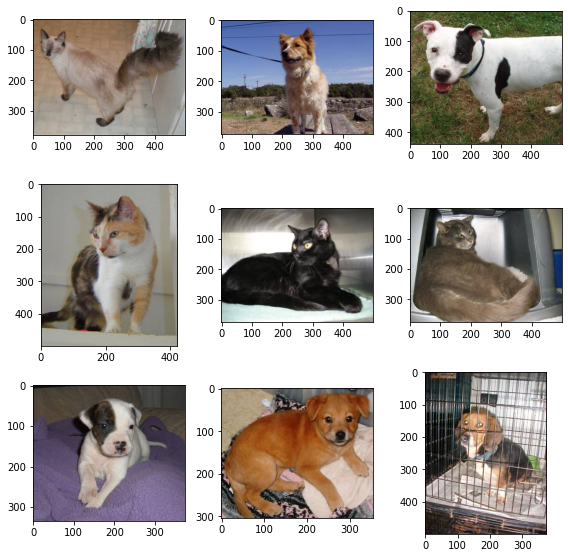

In [ ]:
train_dir = '/tmp/train/'

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(331 + i)
    filename = random.choice([train_dir + x for x in os.listdir(train_dir)])
    img = imread(filename)
    plt.imshow(img)
    
plt.tight_layout()

### Preparing data

In [ ]:
# we have to pre-process our data into their respective directories
# As currently we are having all our images in a single directory
# we have to write a function to create the following directory structure :- 

# dogs-vs-cats-redux-kernels-edition/train/train/
# |
# |__ train_set
# |    |__ cats
# |    |__ dogs
# |
# |__ validaton_set
#     |__ cats
#     |__ dogs

In [ ]:
def create_standard_directories():
    root_dir = '/tmp/'
    subdirs = ['train_set/', 'validation_set/']
    for subdir in subdirs:
        label_dirs = ['cats/', 'dogs/']
        for label_dir in label_dirs:
            newdir = root_dir + subdir + label_dir
            os.makedirs(newdir, exist_ok=True)
            
create_standard_directories()

In [ ]:
def move_images_into_directories():
    random.seed(1)
    validation_ratio = 0.25
    for img in tqdm(os.listdir(train_dir)):
        img_path = train_dir + img
        dst_dir = '/tmp/train_set/'
        if random.random() < validation_ratio:
            dst_dir = '/tmp/validation_set/'
            
        if img.startswith('cat'):
            dst = dst_dir + 'cats/' + img
            move(img_path, dst)
        
        elif img.startswith('dog'):
            dst = dst_dir + 'dogs/' + img
            move(img_path, dst)
        
        
move_images_into_directories()

100%|██████████| 25000/25000 [00:00<00:00, 39772.56it/s]


### Creating 1-Block VGG model

##### Conv_layer -> Maxpooling_layer -> FC -> output_layer

In [ ]:
def define_model():
    model = tf.keras.models.Sequential(name='1_block_VGG')
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

### Image data generator (without any augmentation)

In [ ]:
def data_generator():

    train_generator = ImageDataGenerator(rescale = 1./255)
    train_set_path = '/tmp/train_set/'
    train_data = train_generator.flow_from_directory(
        train_set_path,
        batch_size = 64,
        target_size = (200, 200),
        class_mode = 'binary'
    )

    valid_generator = ImageDataGenerator(rescale = 1./255)
    valid_set_path = '/tmp/validation_set/'
    valid_data = valid_generator.flow_from_directory(
        valid_set_path,
        batch_size = 64,
        target_size = (200, 200),
        class_mode = 'binary'
    )
    
    return train_data, valid_data

### Fitting the model

In [ ]:
def model_fitting():
    
    model = define_model()
    train_data, valid_data = data_generator()
    
    history = model.fit_generator(
        train_data,
        steps_per_epoch = len(train_data),
        validation_data = valid_data,
        validation_steps = len(valid_data),
        epochs = 20,    #50 for 3-Block VGG 
        verbose = 1
    )

    return model, history 
    

In [ ]:
model, history = model_fitting()

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
293/293 [==============================] - 74s 252ms/step - loss: 0.6997 - accuracy: 0.5575 - val_loss: 0.6692 - val_accuracy: 0.6069
Epoch 2/20
293/293 [==============================] - 74s 252ms/step - loss: 0.6532 - accuracy: 0.6090 - val_loss: 0.6371 - val_accuracy: 0.6284
Epoch 3/20
293/293 [==============================] - 72s 247ms/step - loss: 0.6339 - accuracy: 0.6343 - val_loss: 0.6294 - val_accuracy: 0.6424
Epoch 4/20
293/293 [==============================] - 73s 249ms/step - loss: 0.6244 - accuracy: 0.6404 - val_loss: 0.6173 - val_accuracy: 0.6456
Epoch 5/20
293/293 [==============================] - 73s 248ms/step - loss: 0.6012 - accuracy: 0.6683 - val_loss: 0.6139 - val_accuracy: 0.6486
Epoch 6/20
293/293 [==============================] - 73s 248ms/step - loss: 0.6007 - accuracy: 0.6661 - val_loss:

### Plotting accuracy and loss curve for 1-Block VGG

In [ ]:
def plot_accuracy_loss_curves(model, history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

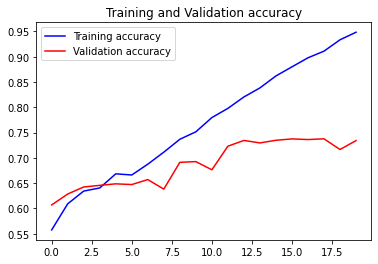

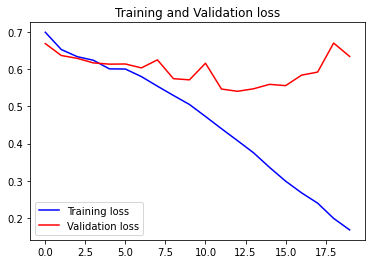

In [ ]:
plot_accuracy_loss_curves(model, history)

##### We can clearly see that our model is overfitting the training data as it is having an accuracy of 94% on training data and 73% on validation data. Therefore we need some regularization. This can be achieved by using image augmentaion technique.

### Image data generator with augmentation

In [ ]:
def data_generator():

    train_generator = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 20,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        zoom_range = 0.1,
        horizontal_flip = True,
    )
    train_set_path = '/tmp/train_set/'
    train_data = train_generator.flow_from_directory(
        train_set_path,
        batch_size = 64,
        target_size = (200, 200),
        class_mode = 'binary'
    )

    valid_generator = ImageDataGenerator(rescale = 1./255)
    valid_set_path = '/tmp/validation_set/'
    valid_data = valid_generator.flow_from_directory(
        valid_set_path,
        batch_size = 64,
        target_size = (200, 200),
        class_mode = 'binary'
    )
    
    return train_data, valid_data

model, history = model_fitting()



Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/20
293/293 [==============================] - 232s 793ms/step - loss: 1.9059 - accuracy: 0.5930 - val_loss: 0.8584 - val_accuracy: 0.5685
Epoch 2/20
293/293 [==============================] - 233s 794ms/step - loss: 0.6431 - accuracy: 0.6549 - val_loss: 0.5980 - val_accuracy: 0.6957
Epoch 3/20
293/293 [==============================] - 234s 798ms/step - loss: 0.5994 - accuracy: 0.6872 - val_loss: 0.5595 - val_accuracy: 0.7065
Epoch 4/20
293/293 [==============================] - 232s 792ms/step - loss: 0.5607 - accuracy: 0.7052 - val_loss: 0.5296 - val_accuracy: 0.7370
Epoch 5/20
293/293 [==============================] - 229s 780ms/step - loss: 0.5539 - accuracy: 0.7164 - val_loss: 0.5309 - val_accuracy: 0.7382
Epoch 6/20
293/293 [==============================] - 224s 766ms/step - loss: 0.5347 - accuracy: 0.7258 - val_loss: 0.6236 - val_accuracy: 0.6819
Epoch 7/20
293/293 [===================

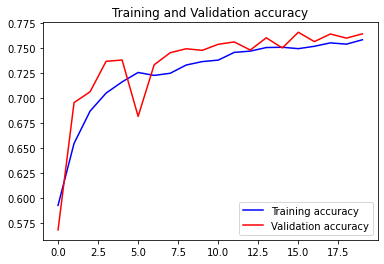

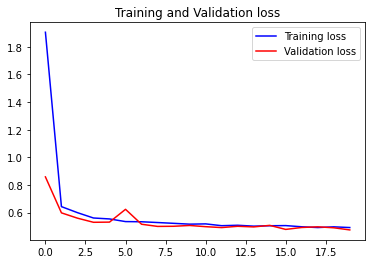

In [ ]:
plot_accuracy_loss_curves(model, history)

##### Our accuracy is still low ~76% as we're having only a single conv layer. Lets create a slightly deeper model and use 50 epochs this time.

### Creating 3-Block VGG model

##### Conv_layer -> Maxpooling_layer -> Conv_layer -> Maxpooling_layer -> Conv_layer -> Maxpooling_layer -> FC -> output_layer

In [ ]:
def define_model():
    model = tf.keras.models.Sequential(name='3_block_VGG')
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
model = define_model()
model.summary()

Model: "3_block_VGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 80000)             

In [ ]:
model, history = model_fitting()

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/50
293/293 [==============================] - 225s 766ms/step - loss: 0.9845 - accuracy: 0.6376 - val_loss: 0.6223 - val_accuracy: 0.6652
Epoch 2/50
293/293 [==============================] - 219s 748ms/step - loss: 0.5622 - accuracy: 0.7146 - val_loss: 0.5410 - val_accuracy: 0.7252
Epoch 3/50
293/293 [==============================] - 219s 748ms/step - loss: 0.5102 - accuracy: 0.7485 - val_loss: 0.4647 - val_accuracy: 0.7792
Epoch 4/50
293/293 [==============================] - 216s 736ms/step - loss: 0.4682 - accuracy: 0.7733 - val_loss: 0.4350 - val_accuracy: 0.7991
Epoch 5/50
293/293 [==============================] - 211s 722ms/step - loss: 0.4406 - accuracy: 0.7937 - val_loss: 0.3908 - val_accuracy: 0.8245
Epoch 6/50
293/293 [==============================] - 209s 714ms/step - loss: 0.4140 - accuracy: 0.8084 - val_loss: 0.3779 - val_accuracy: 0.8271
Epoch 7/50
293/293 [===================

### Plotting accuracy and loss curves for 3-Block VGG model

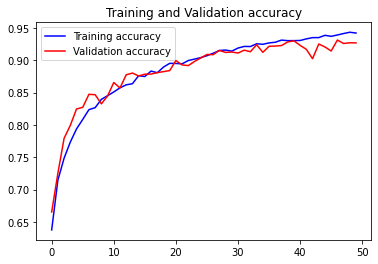

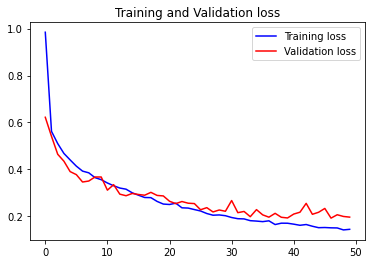

In [ ]:
plot_accuracy_loss_curves(model, history)

##### YAY! Our accuracy boosted from 74% to 92% !!

### Saving model for future use

In [ ]:
model_yaml = model.to_yaml()

with open('/content/drive/My Drive/datasets/cats-vs-dogs/3-Block-VGG.yaml', 'w') as yaml_file:
    yaml_file.write(model_yaml)

model.save_weights('/content/drive/My Drive/datasets/cats-vs-dogs/3-Block-VGG.h5')

<ul><h3>Further improvements that can  be are - </h3><ul>
    <li>Dropout technique can be used to further regularize the training data</li>
    <li>Transfer learning can be used to achieve very high accuracies. Architectures like VGG16, VGG19, InceptionV3, ResNet50 etc. can be used for TL.</li>

#### Thanks for going through my notebook, hope u liked it. 😁🤗